# Fine-Tuning a Vision Language Model with TRL using MPO

_Authored by: [Sergio Paniego](https://github.com/sergiopaniego)_

In this recipe, we'll demonstrate how to fine-tune a [Vision Language Model (VLM)](https://huggingface.co/blog/vlms-2025) using Mixed Preference Optimization (MPO) with the Transformer Reinforcement Learning (TRL) library.

MPO is a training approach that combines multiple optimization objectives and was introduced in the paper [Enhancing the Reasoning Ability of Multimodal Large Language Models via Mixed Preference Optimization](https://huggingface.co/papers/2411.10442). It is part of the [Direct Preference Optimization](https://huggingface.co/papers/2305.18290) \([DPO](https://huggingface.co/docs/trl/main/en/dpo_trainer)\) trainer and works by combining multiple loss functions with different weights, enabling more sophisticated optimization strategies.

We'll fine-tune [Qwen/Qwen2.5-VL-3B-Instruct](https://huggingface.co/Qwen/Qwen2.5-VL-3B-Instruct), a small VLM with strong performance, using a preference dataset to help the model align with desired outputs. Check out [this blog post](https://huggingface.co/blog/dpo_vlm) to learn more about preference optimization for vision-language models.

The dataset we'll use is [HuggingFaceH4/rlaif-v_formatted](https://huggingface.co/datasets/HuggingFaceH4/rlaif-v_formatted), a specially formatted version of the [RLAIF-V dataset](https://huggingface.co/datasets/openbmb/RLAIF-V-Dataset). This dataset contains pairs of `prompt + image`, along with a `chosen` and `rejected` response for each sample. The final goal of the fine-tuning process is to train a model that consistently prefers the `chosen` answers over the `rejected` ones, thereby reducing hallucinations. To achieve this, multiple loss functions will be used in combination.


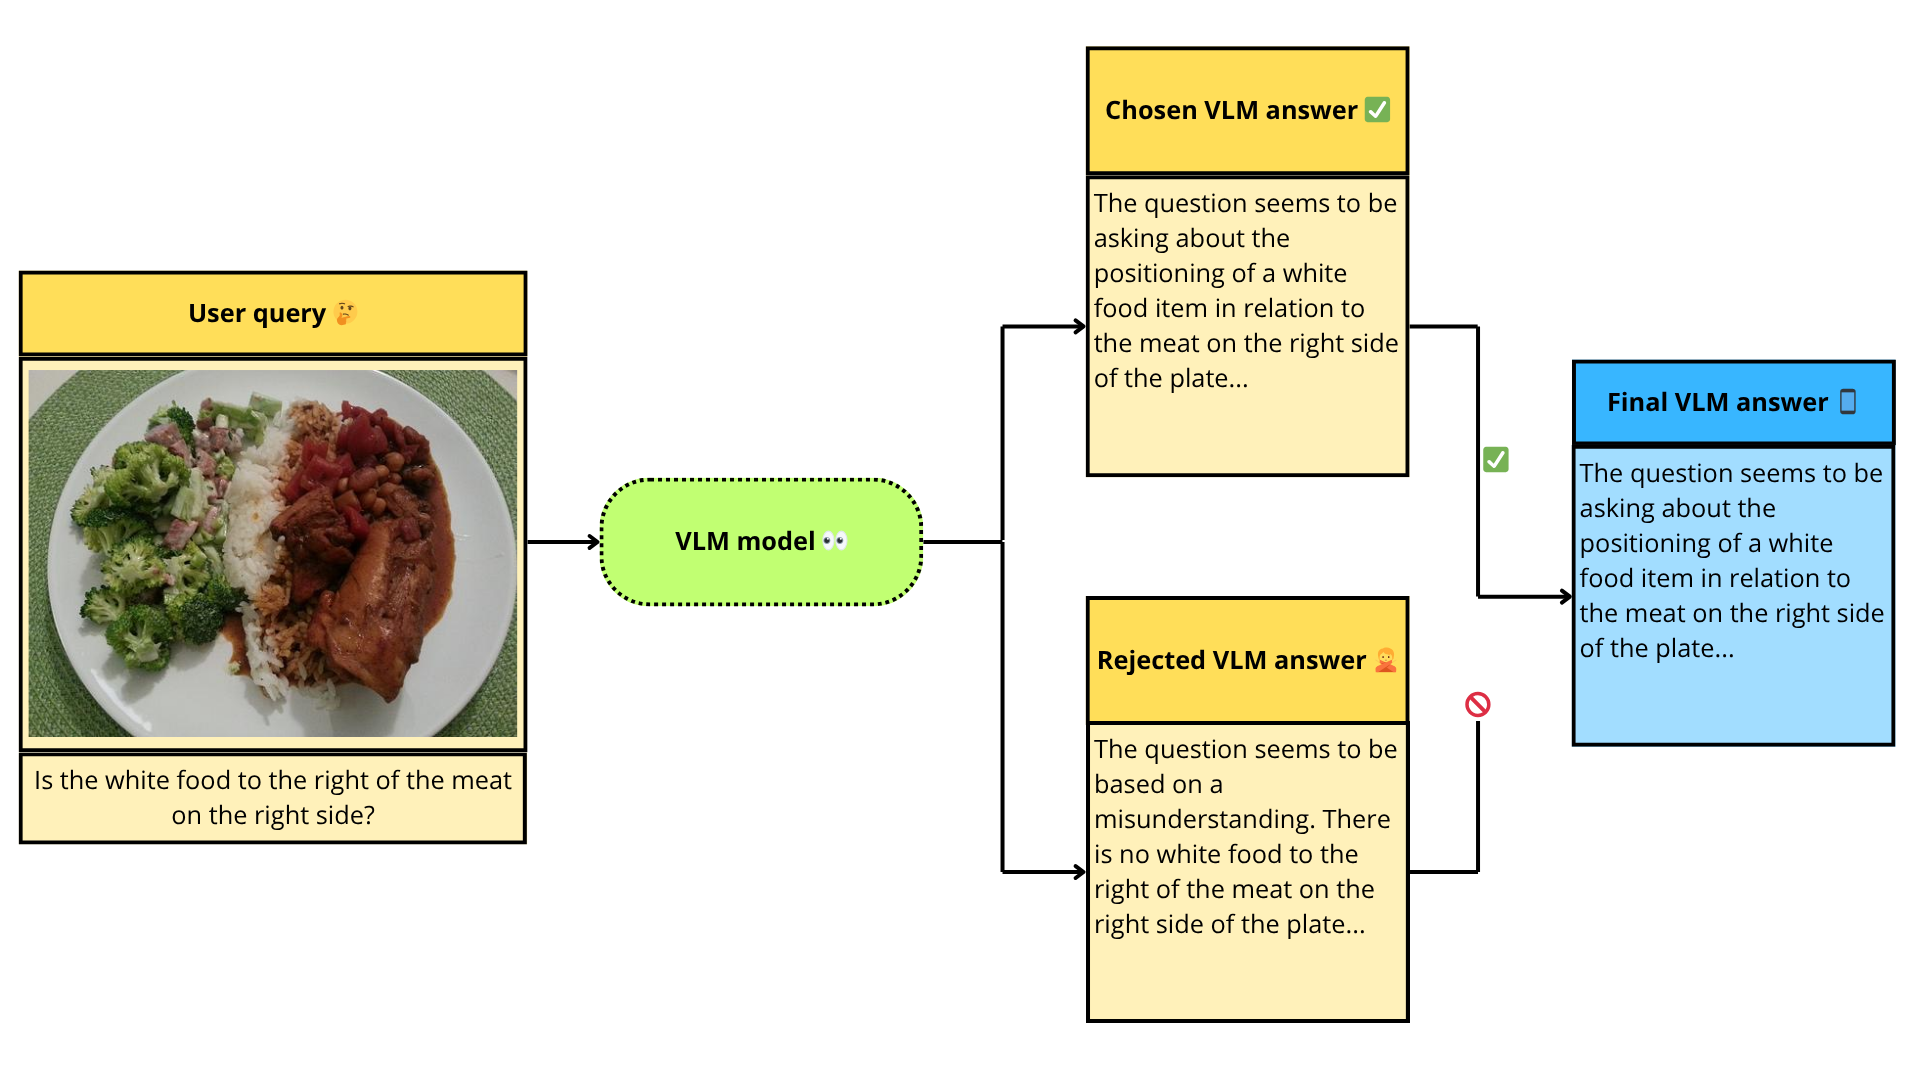

## 1. Install Dependencies

Let's begin by installing the required dependencies:

In [1]:
#https://github.com/huggingface/trl/pull/2544
!git clone https://github.com/huggingface/trl.git
%cd trl

!git checkout mpo

!pip install -q -e .

Cloning into 'trl'...
remote: Enumerating objects: 17507, done.
remote: Counting objects: 100% (259/259), done.
remote: Compressing objects: 100% (143/143), done.
remote: Total 17507 (delta 216), reused 116 (delta 116), pack-reused 17248 (from 3)
Receiving objects: 100% (17507/17507), 11.59 MiB | 17.46 MiB/s, done.
Resolving deltas: 100% (13061/13061), done.
/content/trl
Branch 'mpo' set up to track remote branch 'mpo' from 'origin'.
Switched to a new branch 'mpo'
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.8/494.8 kB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 128.5 MB/s eta 0:00:00
 

In [2]:
!pip install -U -q bitsandbytes qwen-vl-utils==0.0.8

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 MB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.7/39.7 MB 62.4 MB/s eta 0:00:00


We'll authenticate with the Hugging Face Hub using our account to upload and save the fine-tuned model.  
You can generate your access token [here](https://huggingface.co/settings/tokens).


In [3]:
from huggingface_hub import notebook_login

notebook_login()

## 2. Load Dataset

For this recipe, we'll use [HuggingFaceH4/rlaif-v_formatted](https://huggingface.co/datasets/HuggingFaceH4/rlaif-v_formatted), a specially formatted version of the [RLAIF-V dataset](https://huggingface.co/datasets/openbmb/RLAIF-V-Dataset).

In the [paper](https://internvl.github.io/blog/2024-11-14-InternVL-2.0-MPO/) that introduced MPO, the authors also presented [OpenGVLab/MMPR](https://huggingface.co/datasets/OpenGVLab/MMPR), a large-scale multimodal preference dataset built through an efficient pipeline that combines both samples with and without clear ground truths.

For our educational case, we'll use `HuggingFaceH4/rlaif-v_formatted`. However, for best reproduction of the paper's results, we recommend exploring MMPR.  
We'll work with a subset of the dataset for this example.


In [4]:
from datasets import load_dataset

dataset_id = "HuggingFaceH4/rlaif-v_formatted"
train_dataset, test_dataset = load_dataset(dataset_id, split=["train[:1%]", "test[:1%]"])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:86: UserWarning: 
Access to the secret `HF_TOKEN` has not been granted on this notebook.
You will not be requested again.
Please restart the session if you want to be prompted again.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00013.parquet:   0%|          | 0.00/569M [00:00<?, ?B/s]

data/train-00001-of-00013.parquet:   0%|          | 0.00/473M [00:00<?, ?B/s]

data/train-00002-of-00013.parquet:   0%|          | 0.00/448M [00:00<?, ?B/s]

data/train-00003-of-00013.parquet:   0%|          | 0.00/527M [00:00<?, ?B/s]

data/train-00004-of-00013.parquet:   0%|          | 0.00/487M [00:00<?, ?B/s]

data/train-00005-of-00013.parquet:   0%|          | 0.00/531M [00:00<?, ?B/s]

data/train-00006-of-00013.parquet:   0%|          | 0.00/490M [00:00<?, ?B/s]

data/train-00007-of-00013.parquet:   0%|          | 0.00/444M [00:00<?, ?B/s]

data/train-00008-of-00013.parquet:   0%|          | 0.00/526M [00:00<?, ?B/s]

data/train-00009-of-00013.parquet:   0%|          | 0.00/466M [00:00<?, ?B/s]

data/train-00010-of-00013.parquet:   0%|          | 0.00/518M [00:00<?, ?B/s]

data/train-00011-of-00013.parquet:   0%|          | 0.00/476M [00:00<?, ?B/s]

data/train-00012-of-00013.parquet:   0%|          | 0.00/510M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/399M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/78975 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/4157 [00:00<?, ? examples/s]

Let's include a quick check to ensure the images are in RGB format. If not, we'll convert them accordingly.

In [5]:
from PIL import Image

def ensure_rgb(example):
    # Convert the image to RGB if it's not already
    image = example["images"][0]
    if isinstance(image, Image.Image):
        if image.mode != "RGB":
            image = image.convert("RGB")
        example["images"] = [image]
    return example


# Apply the transformation to the dataset (change num_proc depending on the available compute)
train_dataset = train_dataset.map(ensure_rgb, num_proc=8)
test_dataset = test_dataset.map(ensure_rgb, num_proc=8)

Map (num_proc=8):   0%|          | 0/790 [00:00<?, ? examples/s]

Map (num_proc=8):   0%|          | 0/42 [00:00<?, ? examples/s]

Let's inspect a sample to understand its structure.  
As we can see, each sample contains a `chosen`, `rejected`, `image`, and `prompt`.  
Our goal is to fine-tune the model to prefer the `chosen` answers using MPO.

In [6]:
train_dataset[5]

{'chosen': [{'content': [{'text': 'The question seems to be asking about the positioning of a white food item in relation to the meat on the right side of the plate. However, there is no white food item clearly visible to the right of the meat on the right side of the plate in the image provided. The only white food items present are the rice and beans, which are located more centrally on the plate, not to the right of the meat. Therefore, based on the visual information available, it cannot be confirmed that there is a white food item to the right of the meat on the right side of the plate.',
     'type': 'text'}],
   'role': 'assistant'}],
 'rejected': [{'content': [{'text': 'The question seems to be based on a misunderstanding. There is no white food to the right of the meat on the right side of the plate. The white food is actually rice, which is positioned to the left of the meat and not to the right. The meat in question appears to be the pork chop or pork belly that is on the ri

Let's check the image for that particular sample:

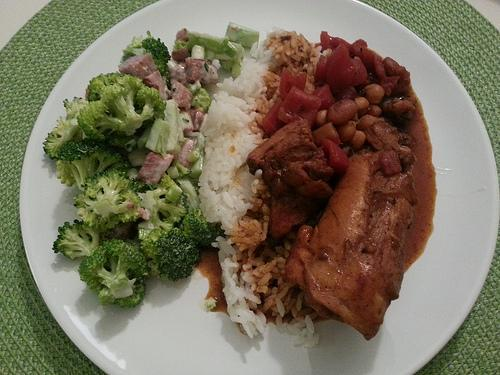

In [7]:
train_dataset[5]['images'][0]

## 3. Fine-Tune the Model with TRL using MPO

As previously described, we'll leverage `trl`, since this library provides everything we need to train using MPO while abstracting away some of the complexity we don't need to handle for this particular case.

The MPO trainer accepts a list of `loss_type`s. A full list of available loss functions is provided in the DPO trainer documentation [here](https://huggingface.co/docs/trl/main/en/dpo_trainer#loss-functions).  
As mentioned earlier, MPO is a particular case of the DPO trainer, so we can use it by specifying a list of loss types and their corresponding weights.

The possible values for `loss_type` are:

- `"sigmoid"`: Sigmoid loss from the original [DPO](https://huggingface.co/papers/2305.18290) paper.
- `"hinge"`: Hinge loss on the normalized likelihood from the [SLiC](https://huggingface.co/papers/2305.10425) paper.
- `"ipo"`: IPO loss from the [IPO](https://huggingface.co/papers/2310.12036) paper.
- `"exo_pair"`: Pairwise EXO loss from the [EXO](https://huggingface.co/papers/2402.00856) paper.
- `"nca_pair"`: Pairwise NCA loss from the [NCA](https://huggingface.co/papers/2402.05369) paper.
- `"robust"`: Unbiased estimate of the DPO loss that is robust to preference noise, from the [Robust DPO](https://huggingface.co/papers/2403.00409) paper.
- `"bco_pair"`: Pairwise BCO loss from the [BCO](https://huggingface.co/papers/2404.04656) paper.
- `"sppo_hard"`: SPPO loss with hard labels from the [SPPO](https://huggingface.co/papers/2405.00675) paper.
- `"aot"`: AOT loss for paired datasets from the [AOT](https://huggingface.co/papers/2406.05882) paper.
- `"aot_pair"`: AOT loss for unpaired datasets from the same [AOT](https://huggingface.co/papers/2406.05882) paper.
- `"discopop"`: DiscoPOP (also known as Log-Ratio Modulated Loss, LRML) from the [DiscoPOP](https://huggingface.co/papers/2406.08414) paper.
- `"apo_zero"`: APO-zero loss from the [APO](https://huggingface.co/papers/2408.06266) paper.
- `"apo_down"`: APO-down loss from the same [APO](https://huggingface.co/papers/2408.06266) paper.
- `"sft"`: Negative log-likelihood loss (standard supervised fine-tuning loss).

In the image below, you can see the improvements reported in the MPO paper for the InternVL2-8B model using this training strategy.


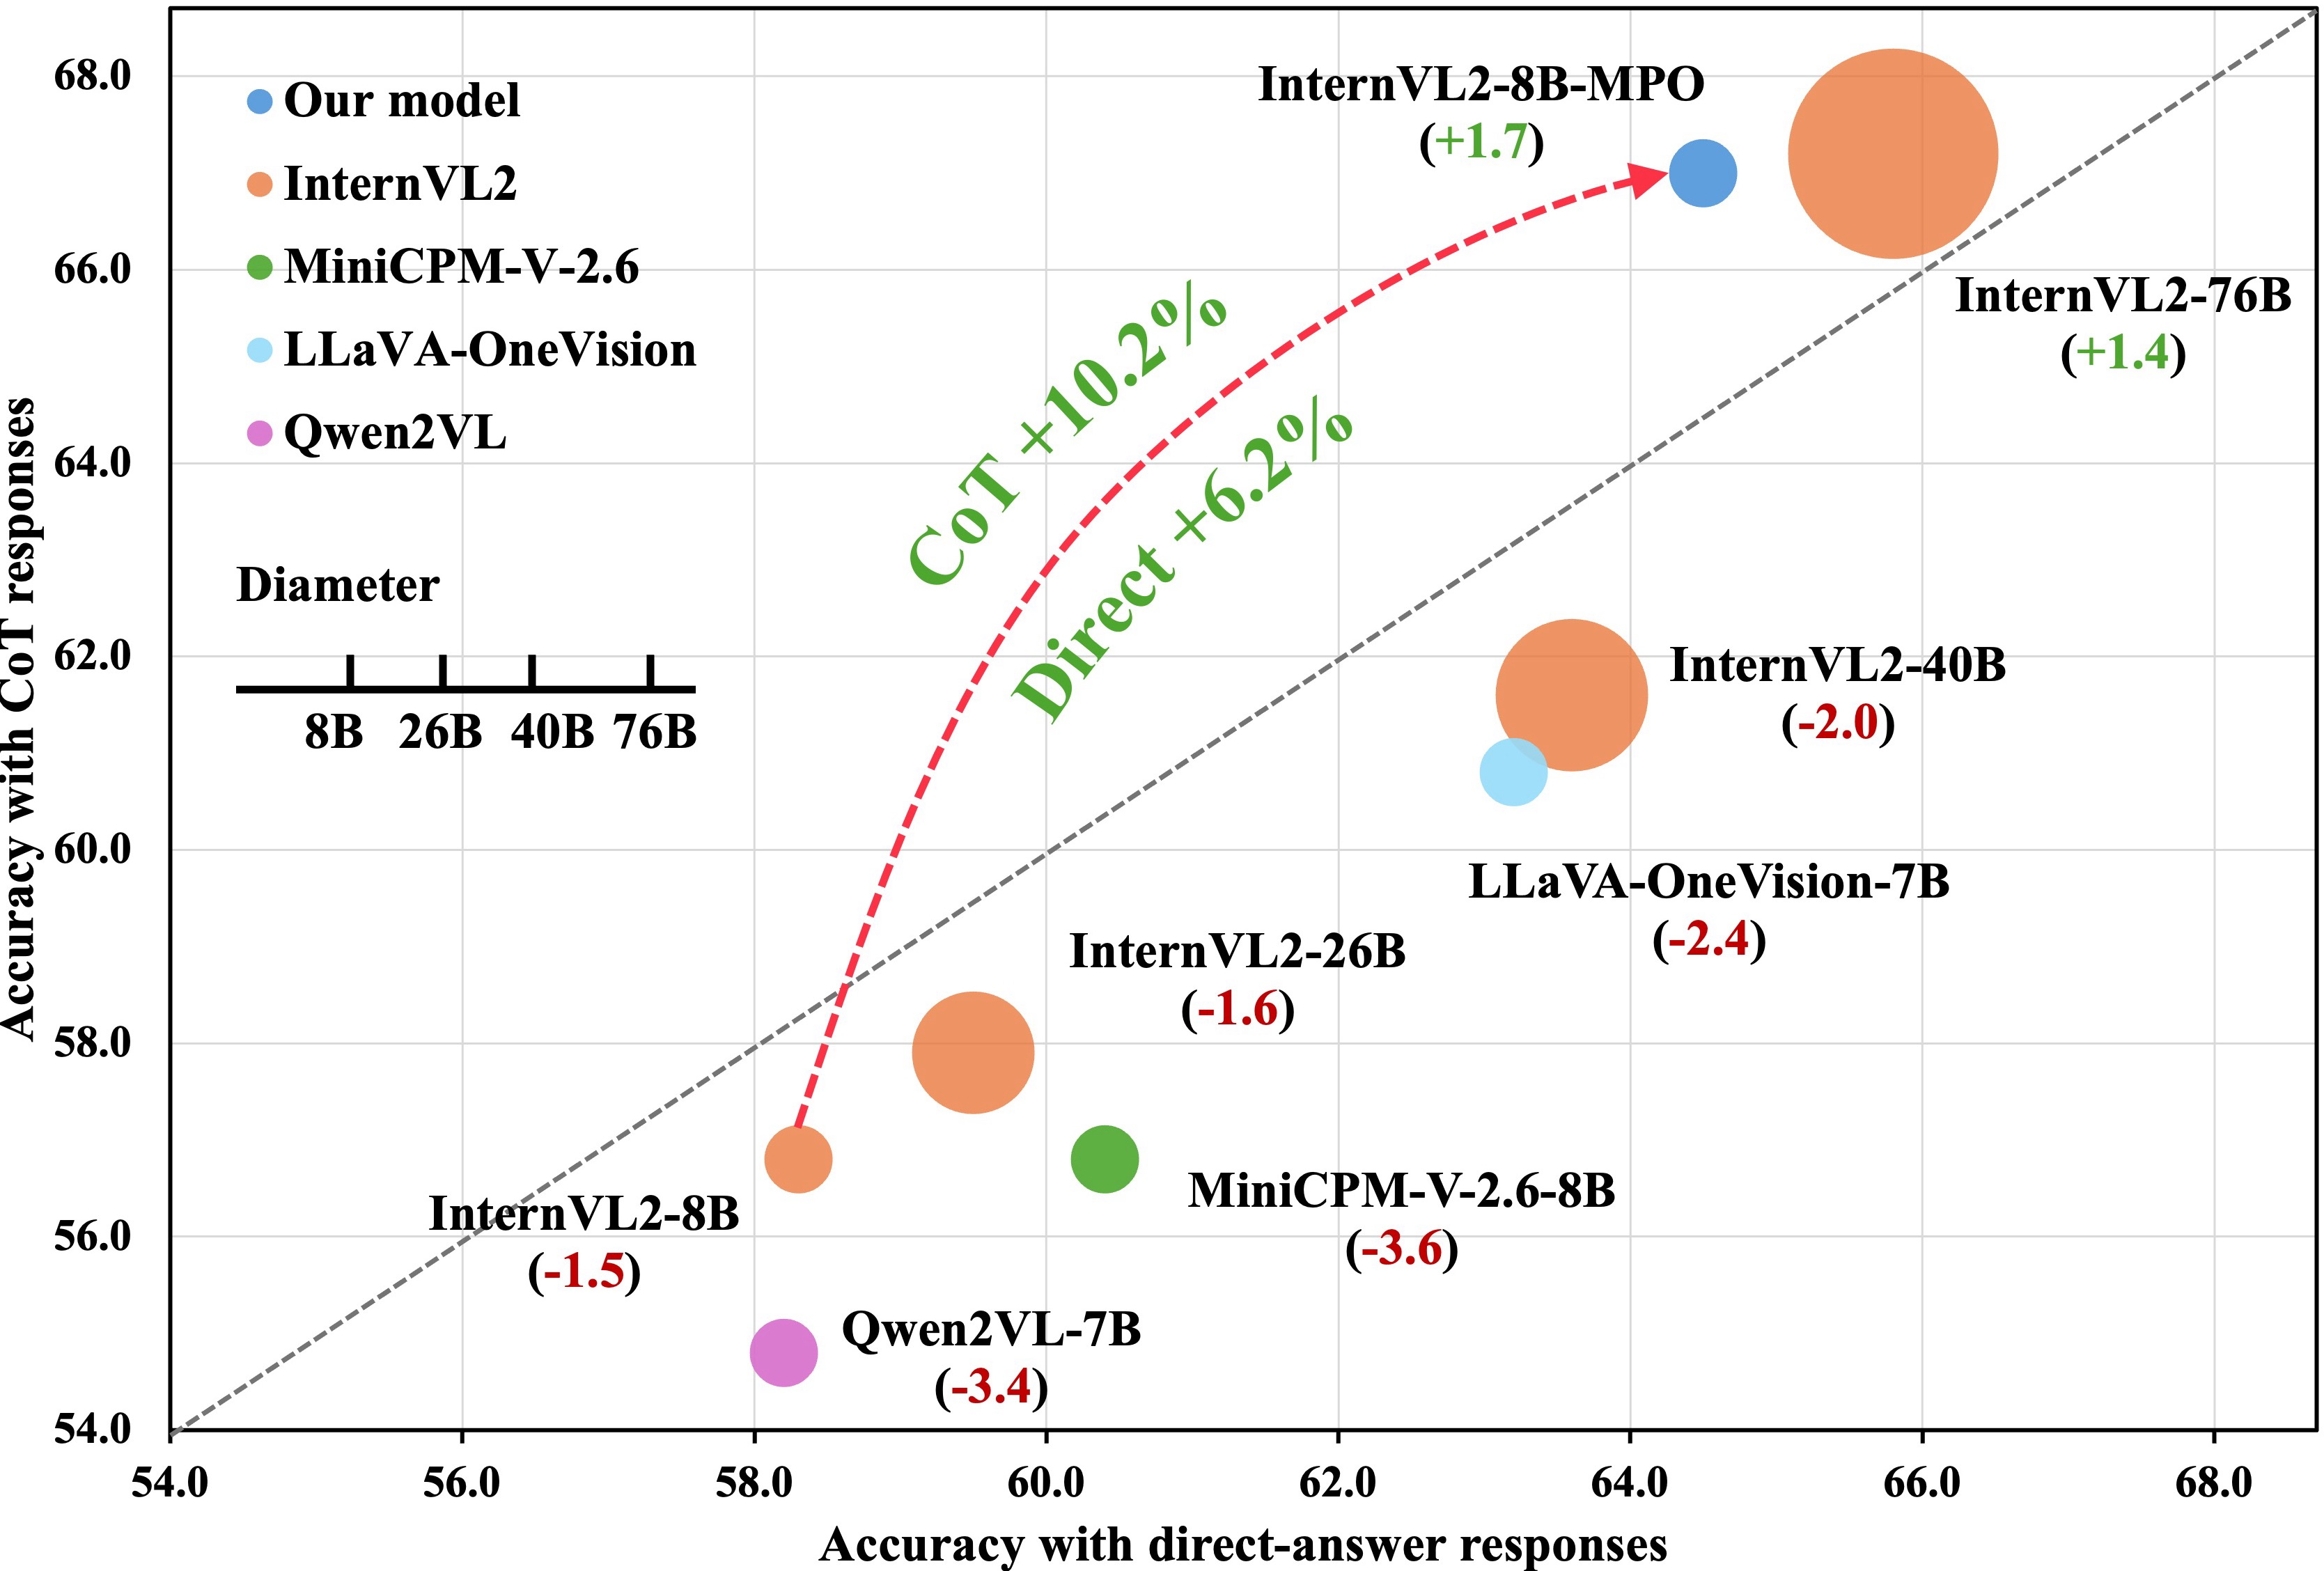

Esta 2 veces aqui: https://github.com/huggingface/trl/blob/mpo/trl/trainer/dpo_config.py y otra en los docs: https://huggingface.co/docs/trl/main/en/dpo_trainer#loss-functions

### 3.1 Load the Quantized Model for Training

Let's load the model. In this example, we'll use [Qwen/Qwen2.5-VL-3B-Instruct](https://huggingface.co/Qwen/Qwen2.5-VL-3B-Instruct), a compact Vision Language Model (VLM) with strong performance.

With the original MPO paper, the authors released a [collection](https://huggingface.co/collections/OpenGVLab/internvl25-mpo-6753fed98cd828219b12f849) of checkpoints fine-tuned with this technique for [InternVL2.5](https://huggingface.co/collections/OpenGVLab/internvl25-673e1019b66e2218f68d7c1c), another high-performing VLM.

We chose Qwen2.5-VL-3B-Instruct for its straightforward integration with the `transformers` library, although InternVL2.5 is the original model used in the paper.

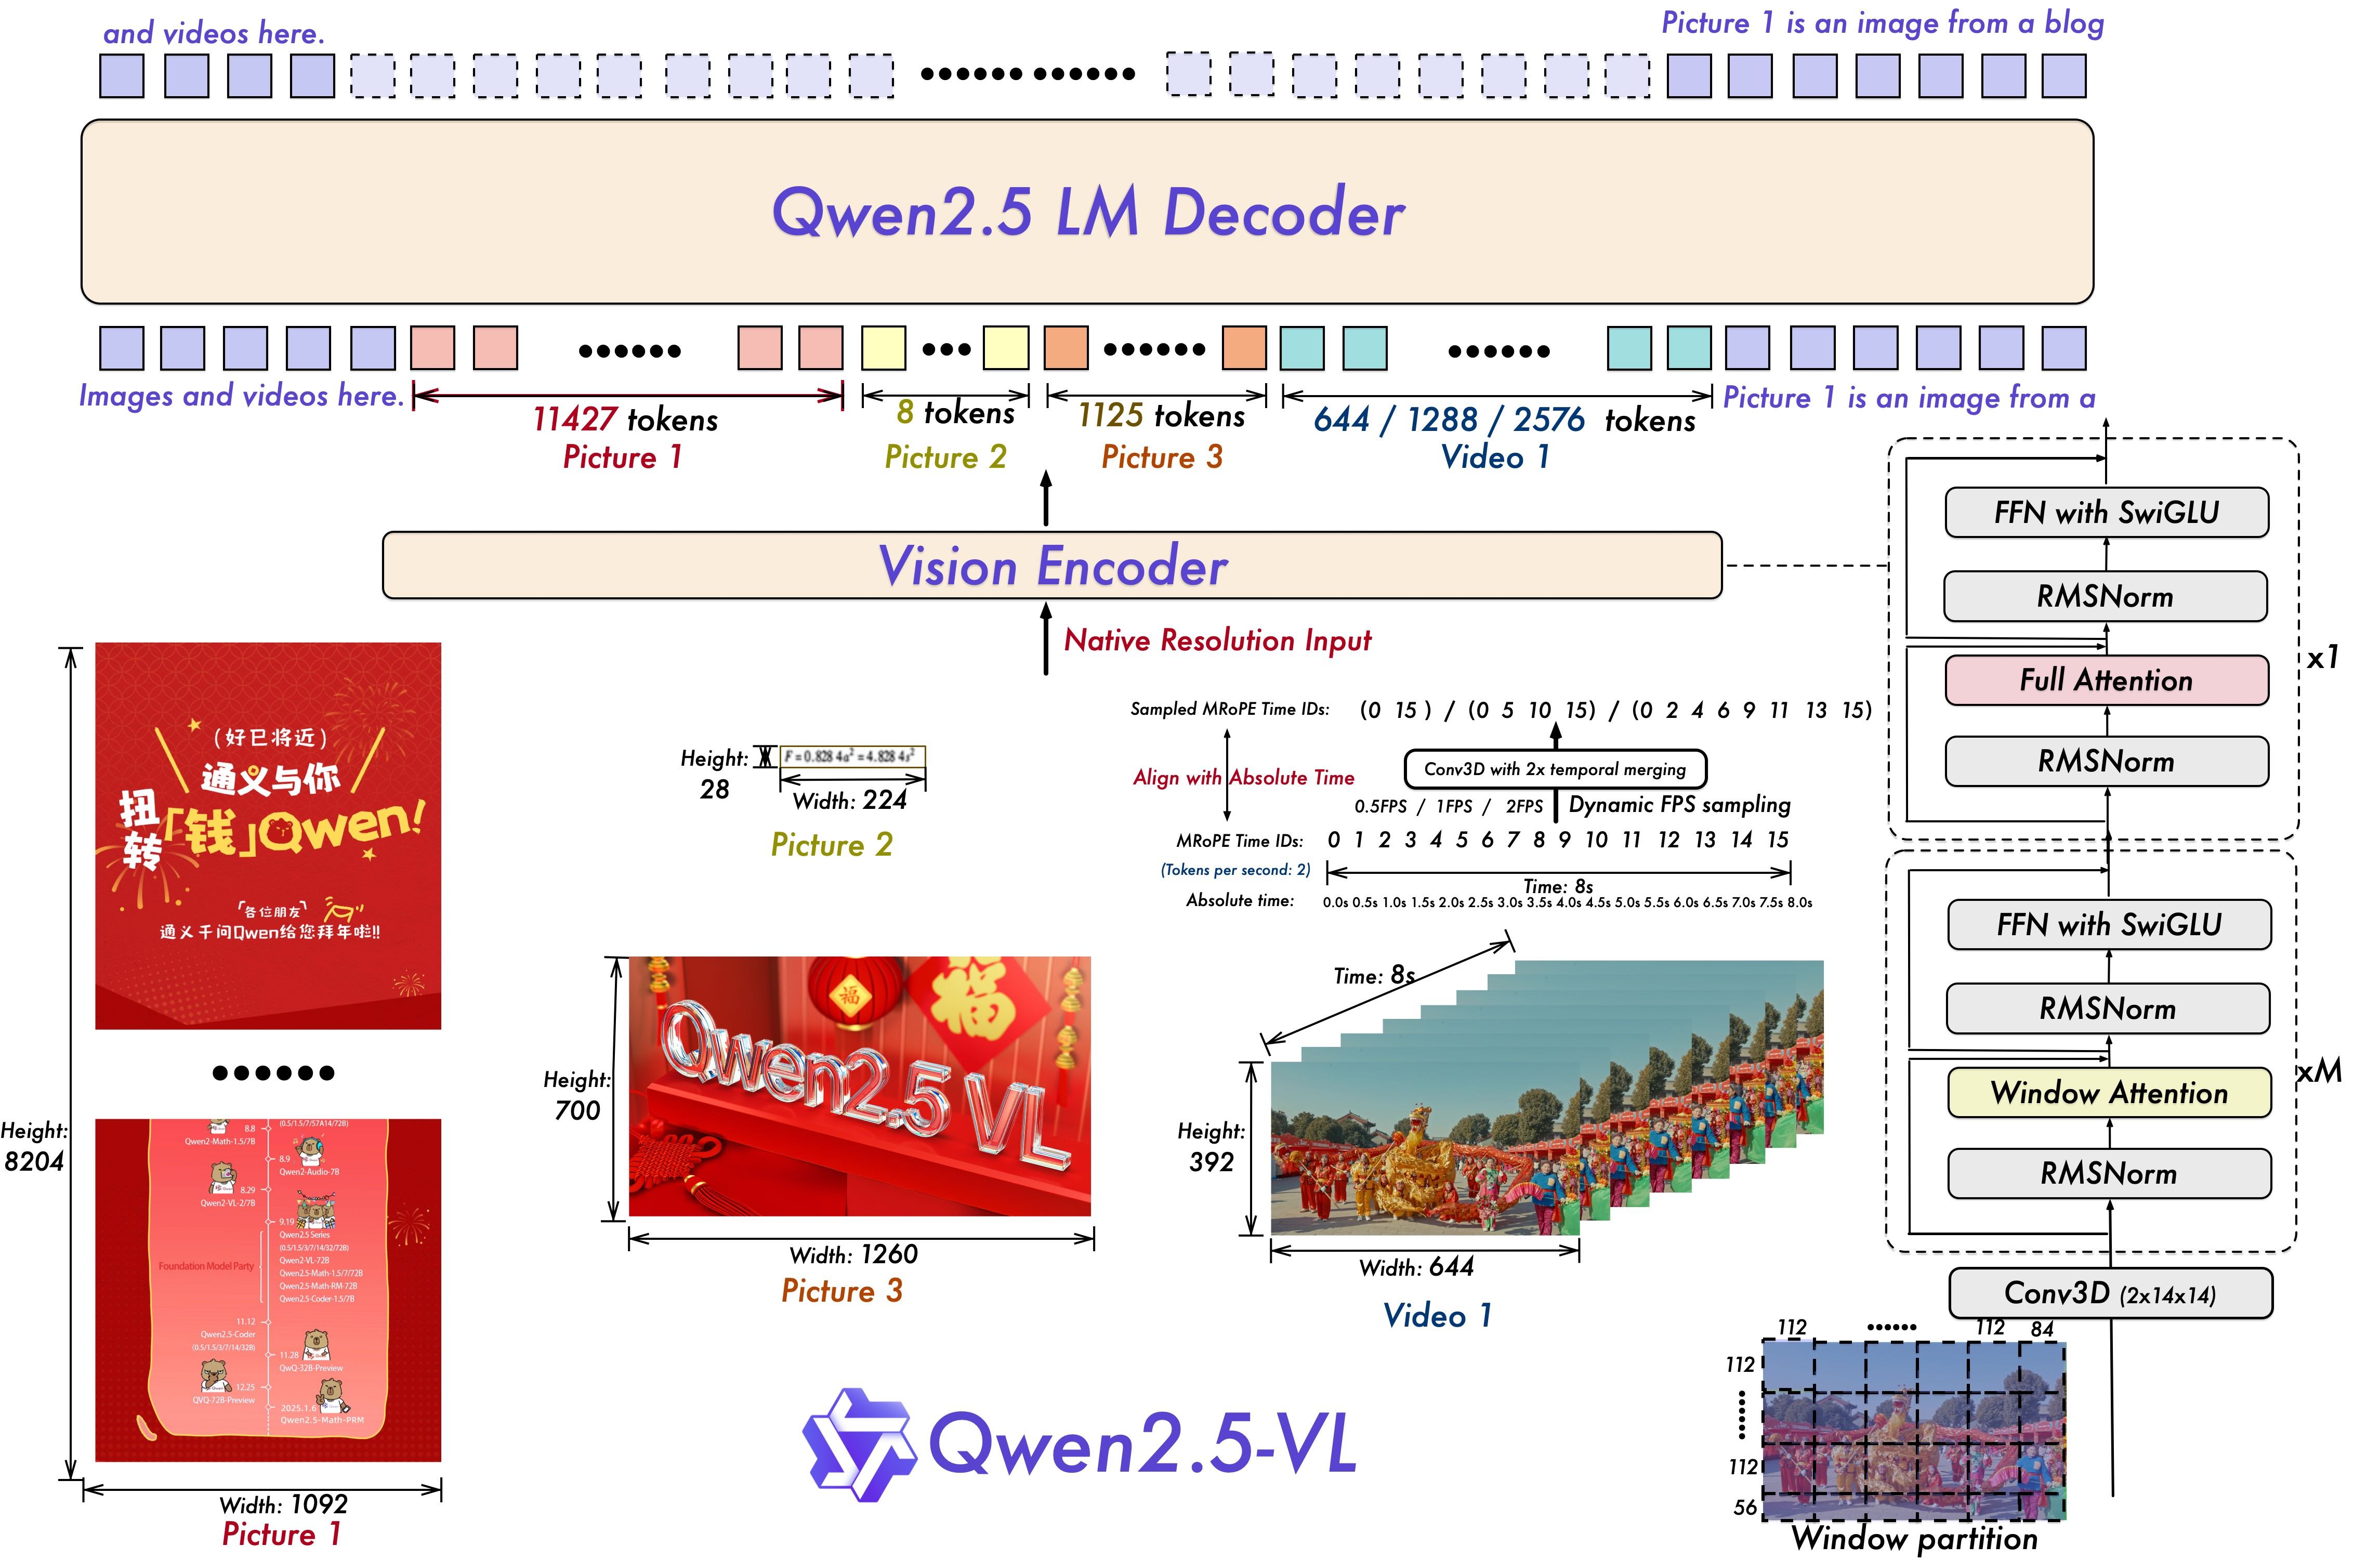

In [8]:
import torch
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor

model_id = "Qwen/Qwen2.5-VL-3B-Instruct"

In [9]:
from transformers import BitsAndBytesConfig

# BitsAndBytesConfig int-4 config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True, bnb_4bit_use_double_quant=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.bfloat16
)

# Load model and tokenizer
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype=torch.bfloat16,
    quantization_config=bnb_config,
    #_attn_implementation="flash_attention_2",
)
processor = AutoProcessor.from_pretrained(model_id, use_fast=True)

config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.53G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/216 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.


chat_template.json: 0.00B [00:00, ?B/s]

### 3.2 Set Up QLoRA

Now that we have the model and processor loaded, let's set up QLoRA and the DPOConfig, where we will set up the losses list and its corresponding weights.  
These configurations enable efficient fine-tuning and optimization tailored for our training objectives.

In [10]:
from peft import LoraConfig, get_peft_model

# Configure LoRA
peft_config = LoraConfig(
    r=8,
    lora_alpha=8,
    lora_dropout=0.1,
    target_modules=["down_proj", "o_proj", "k_proj", "q_proj", "gate_proj", "up_proj", "v_proj"],
    use_dora=True,
    init_lora_weights="gaussian",
)

# Apply PEFT model adaptation
peft_model = get_peft_model(model, peft_config)

# Print trainable parameters
peft_model.print_trainable_parameters()

trainable params: 19,868,416 || all params: 3,774,491,392 || trainable%: 0.5264


### 3.3 MPO via `DPOConfig`

To configure MPO training using the `DPOConfig`, simply provide a list of loss types using the `loss_type` parameter. This can be passed as either a Python list or a comma-separated string. Optionally, you can specify a corresponding list of `loss_weights` to control the relative importance of each loss during optimization. If omitted, all losses default to a weight of `1.0`.

For example, following the setup described in the original MPO paper, you can define:

`loss_type = ["sigmoid", "bco_pair", "sft"]`

`loss_weights = [1.0, 0.5, 0.1]`

This corresponds to:

> *MPO is defined as a combination of the preference loss (L_p), the quality loss (L_q), and the generation loss (L_g).*


For more details on each available loss type and how they affect training, refer to the [official documentation](https://huggingface.co/docs/trl/main/en/dpo_trainer#loss-functions).

All other configuration options follow the standard [`DPOConfig`](https://huggingface.co/docs/trl/main/en/dpo_trainer) format and can be adjusted based on your available compute resources.


In [11]:
from trl import DPOConfig

training_args = DPOConfig(
    output_dir="Qwen2.5-VL-3B-Instruct-trl-mpo-rlaif-v",

    loss_type=["sigmoid", "bco_pair", "sft"],
    loss_weights=[1.0, 0.5, 0.1],  # Corresponding weights

    bf16=False,
    gradient_checkpointing=False,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=8,
    num_train_epochs=5,
    dataset_num_proc=1,  # tokenization will use 1 processes
    dataloader_num_workers=8,  # data loading will use 8 workers
    logging_steps=10,
    report_to="tensorboard",
    push_to_hub=True,
    save_strategy="steps",
    save_steps=10,
    save_total_limit=1,
    eval_steps=10,  # Steps interval for evaluation
    eval_strategy="steps",

)

As we can see, setting MPO vs DPO is straightforward and only requires two additional parameters in the `DPOConfig`. Finally, we can initialize the `DPOTrainer` and start training the model.

In [12]:
from trl import DPOTrainer

trainer = DPOTrainer(
    model=peft_model,
    ref_model=None,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    processing_class=processor,
)

Extracting prompt in train dataset:   0%|          | 0/790 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/790 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/790 [00:00<?, ? examples/s]

Extracting prompt in eval dataset:   0%|          | 0/42 [00:00<?, ? examples/s]

Applying chat template to eval dataset:   0%|          | 0/42 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/42 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModel`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [ ]:
trainer.train()

## 4. Testing the Fine-Tuned Model

We have fine-tuned our model using MPO. Now, let's evaluate its performance on a sample to see how it behaves in practice.


In [13]:
trained_model_id = "sergiopaniego/Qwen2.5-VL-3B-Instruct-trl-mpo-rlaif-v"
model_id = "Qwen/Qwen2.5-VL-3B-Instruct"

In [14]:
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor
from peft import PeftModel
import torch

base_model = Qwen2_5_VLForConditionalGeneration.from_pretrained(model_id, torch_dtype=torch.bfloat16, device_map="auto")
trained_model = PeftModel.from_pretrained(base_model, trained_model_id).eval()

trained_processor = AutoProcessor.from_pretrained(model_id, use_fast=True)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

adapter_config.json: 0.00B [00:00, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/79.6M [00:00<?, ?B/s]

In [15]:
test_dataset[0]

{'chosen': [{'content': [{'text': 'The image features a modern, multi-colored train parked on a train track, occupying a significant portion of the scene. The train has a unique and striking design, with red, white, and blue colors, as well as yellow accents. It appears to be a high-speed train, indicating its advanced engineering and potential for fast travel.\n\nThe train is situated next to a platform, suggesting that it may be at a train station. The overall scene conveys a sense of transportation and modern technology, with the vibrant and sleek train as the main subject.',
     'type': 'text'}],
   'role': 'assistant'}],
 'rejected': [{'content': [{'text': 'The image features a modern, colorful train parked on a set of train tracks. The train has a striking design, with red, white, and blue colors as well as yellow accents. It appears to be a high-speed train, ready for departure.\n\nThe train spans a significant portion of the image, from the left to the right side. The train tr

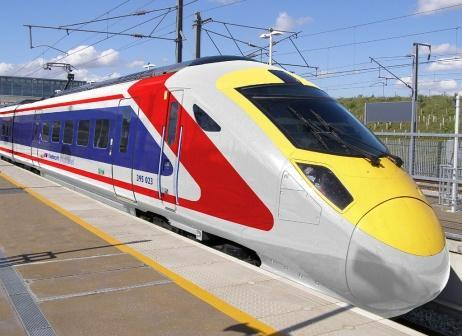

In [16]:
test_dataset[0]["images"][0]

In [24]:
from qwen_vl_utils import process_vision_info

def generate_text_from_sample(model, processor, sample, max_new_tokens=1024, device="cuda"):
    # Prepare the text input by applying the chat template
    sample["prompt"][0]["content"][0]["image"] = sample["images"][0]
    text_input = processor.apply_chat_template(sample["prompt"], add_generation_prompt=True)

    image_inputs, _ = process_vision_info(sample["prompt"])
    inputs = processor(
        text=[text_input],
        images=image_inputs,
        videos=None,
        padding=True,
        return_tensors="pt",
    )
    inputs = inputs.to("cuda")

    # Inference: Generation of the output
    generated_ids = model.generate(**inputs, max_new_tokens=max_new_tokens, do_sample=False)

    trimmed_generated_ids = [out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)]

    output_text = processor.batch_decode(
        trimmed_generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )

    return output_text[0]

In [29]:
pretrained_output = generate_text_from_sample(model, processor, test_dataset[0])
print('\n\n>>> Pretrained model output:\n\n')
print(pretrained_output)
trained_output = generate_text_from_sample(trained_model, trained_processor, test_dataset[0])
print('\n\n>>> Fine tuned model output:\n\n')
print(trained_output)

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.




>>> Pretrained model output:


The image depicts a modern high-speed train at a station platform. The train has a sleek, aerodynamic design with a streamlined front and a yellow nose. The body of the train is primarily white, with red and blue accents along its side. The windows are rectangular and evenly spaced along the length of the train.

The platform itself is made of concrete and features a yellow safety line painted along the edge to indicate where passengers should stand to avoid being hit by the train doors when it arrives or departs. The platform is equipped with metal handrails for passengers to hold onto while waiting.

In the background, there are several elements that provide context to the setting. There are multiple power lines and poles, suggesting that the train is electrically powered. The sky is clear with a few scattered clouds, indicating fair weather conditions. Additionally, there are some greenery and possibly other infrastructure structures visible in the d

## 5. Continue Your Learning Journey 🧑‍🎓️

This is not the end of your learning journey! If you enjoyed this content and want to dive deeper into MPO, `trl`, or Vision-Language Models, check out the following resources:

- [Preference Optimization for Vision Language Models with TRL](https://huggingface.co/blog/dpo_vlm)
- [Enhancing the Reasoning Ability of Multimodal Large Language Models via Mixed Preference Optimization](https://internvl.github.io/blog/2024-11-14-InternVL-2.0-MPO/)
- [MPO in the TRL documentation](https://huggingface.co/docs/trl/main/en/dpo_trainer)
- [Vision Language Models (Better, Faster, Stronger)](https://huggingface.co/blog/vlms-2025)
- [Explore more multimodal recipes in the Hugging Face Open-Source AI Cookbook](https://huggingface.co/learn/cookbook)